## LOAD DATASET

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
train_dir = '/content/drive/MyDrive/data/Split_0.2/train_dir/'
test_dir = '/content/drive/MyDrive/data/Split_0.2/validation_dir/'

In [3]:
train_segar = train_dir + 'Fresh'
train_busuk = train_dir + 'Not_fresh'
test_segar = test_dir + 'Fresh'
test_busuk = test_dir + 'Not_fresh'

In [4]:
import os
train_segar_names = os.listdir(train_segar)
train_busuk_names = os.listdir(train_busuk)
test_segar_names = os.listdir(test_segar)
test_busuk_names = os.listdir(test_busuk)

In [5]:
print(len(train_segar_names))
print(len(train_busuk_names))
print(len(test_segar_names))
print(len(test_busuk_names))

120
120
30
30


## PREPROCESSING DATASET

In [48]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_data = train_datagen.flow_from_directory(
    train_dir,
    class_mode='categorical',
    target_size=(256, 256),
    batch_size=32
)

Found 240 images belonging to 2 classes.


In [49]:
train_data.class_indices

{'Fresh': 0, 'Not_fresh': 1}

In [50]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    class_mode='categorical',
    target_size=(256, 256),
    batch_size=16,
    shuffle=False
)

Found 60 images belonging to 2 classes.


In [51]:
test_data.class_indices

{'Fresh': 0, 'Not_fresh': 1}

Sample Spinach not fresh image:


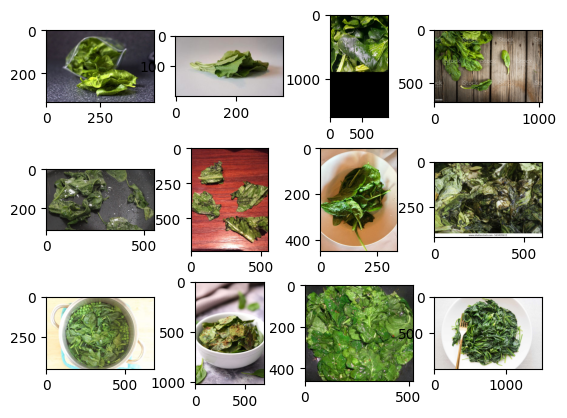

In [60]:
import os
print("Sample Spinach not fresh image:")
train_not_fresh_dir = os.path.join(train_dir, 'Not_fresh')

for n in range(12):
  plt.subplot(int(12/6)+1, 4, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(load_img(f"{os.path.join(train_not_fresh_dir, os.listdir(train_not_fresh_dir)[n])}"))
  #plt.axis('off')
plt.show()

Sample Spinach not fresh image:


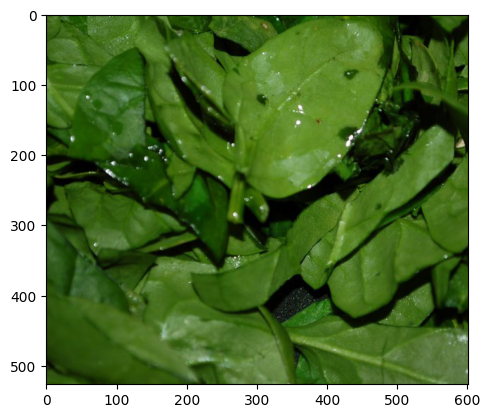

In [79]:
import os
print("Sample Spinach not fresh image:")
train_not_fresh_dir1 = os.path.join(train_dir, 'Not_fresh')
plt.imshow(load_img(f"{os.path.join(train_not_fresh_dir1, os.listdir(train_incidal_dir)[15])}"))
plt.show()

## BUILDING THE MODEL

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [7]:
base_model = InceptionV3(input_shape=(256,256,3), include_top = False)

87910968/87910968 [==============================] - 0s 0us/step


In [9]:
for layer in base_model.layers:
  layer.trainable = False

In [8]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 36.5 MB/s eta 0:00:00


In [10]:
import tensorflow_addons as tfa


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [23]:
x = Flatten()(base_model.output)
x = Dense(units=2, activation='sigmoid')(x)

#Final model
model = Model(base_model.input, x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss=tensorflow.keras.losses.binary_crossentropy, 
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=2)])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

## CALLBACKs AND TRAINING THE MODEL

In [24]:
from tensorflow.keras.callbacks import Callback

#creates a custom callback class
class CustomCallback(Callback):
    """
    This callback will stop the model from training once the model reaches 95% accuracy on the training data
    """
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print('Accuracy above 95% -- Stopping Training')
            self.model.stop_training = True #stops model training

callbacks = CustomCallback()

# Train the model with the custom callback
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    verbose=1,
    callbacks=[callbacks]
)


Epoch 1/50
8/8 [==============================] - 62s 7s/step - loss: 1.0887 - accuracy: 0.7042 - f1_score: 0.7035 - val_loss: 0.8620 - val_accuracy: 0.8500 - val_f1_score: 0.8465
Epoch 2/50
8/8 [==============================] - 65s 9s/step - loss: 0.8443 - accuracy: 0.8417 - f1_score: 0.8416 - val_loss: 0.8163 - val_accuracy: 0.9000 - val_f1_score: 0.8990
Epoch 3/50
8/8 [==============================] - 65s 9s/step - loss: 0.6837 - accuracy: 0.8750 - f1_score: 0.8750 - val_loss: 0.5205 - val_accuracy: 0.9333 - val_f1_score: 0.9333
Epoch 4/50
8/8 [==============================] - 65s 8s/step - loss: 0.4531 - accuracy: 0.9042 - f1_score: 0.9042 - val_loss: 0.5321 - val_accuracy: 0.9000 - val_f1_score: 0.8999
Epoch 5/50
8/8 [==============================] - 54s 7s/step - loss: 0.2709 - accuracy: 0.9292 - f1_score: 0.9292 - val_loss: 0.5532 - val_accuracy: 0.8833 - val_f1_score: 0.8833
Epoch 6/50
8/8 [==============================] - 64s 8s/step - loss: 0.8662 - accuracy: 0.8292 - f1

In [47]:
'''
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score

# Creates a custom callback class
class CustomCallback(tensorflow.keras.callbacks.Callback):
    """
    This callback will stop the model from training once the F1-score on the training data reaches a certain threshold
    """
    def __init__(self, threshold):
        super(CustomCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(train_data).argmax(axis=1)  # Predicted labels
        y_true = train_data.classes  # Ground truth labels

        f1 = f1_score(y_true, y_pred)

        if f1 > self.threshold:
            print('F1-score above {} -- Stopping Training'.format(self.threshold))
            self.model.stop_training = True  # Stops model training

# Set the threshold for F1-score
threshold = 0.95

callbacks = [CustomCallback(threshold), EarlyStopping(monitor='val_loss', patience=3)]

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)
'''

'\nfrom tensorflow.keras.callbacks import Callback\nfrom tensorflow.keras.callbacks import EarlyStopping\nfrom sklearn.metrics import f1_score\n\n# Creates a custom callback class\nclass CustomCallback(tensorflow.keras.callbacks.Callback):\n    """\n    This callback will stop the model from training once the F1-score on the training data reaches a certain threshold\n    """\n    def __init__(self, threshold):\n        super(CustomCallback, self).__init__()\n        self.threshold = threshold\n\n    def on_epoch_end(self, epoch, logs={}):\n        y_pred = self.model.predict(train_data).argmax(axis=1)  # Predicted labels\n        y_true = train_data.classes  # Ground truth labels\n\n        f1 = f1_score(y_true, y_pred)\n\n        if f1 > self.threshold:\n            print(\'F1-score above {} -- Stopping Training\'.format(self.threshold))\n            self.model.stop_training = True  # Stops model training\n\n# Set the threshold for F1-score\nthreshold = 0.95\n\ncallbacks = [CustomCall

In [27]:
h = history.history
h.keys()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])

Text(0.5, 1.0, 'Training and validation loss')

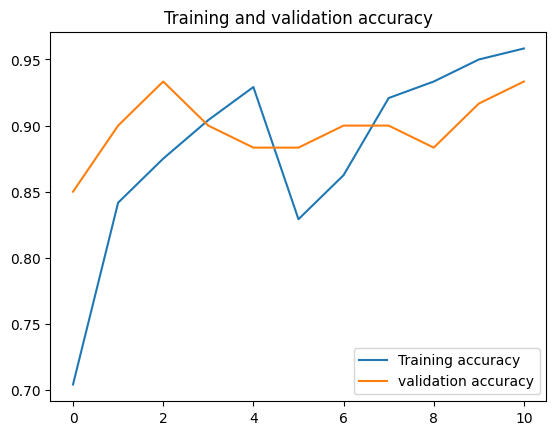

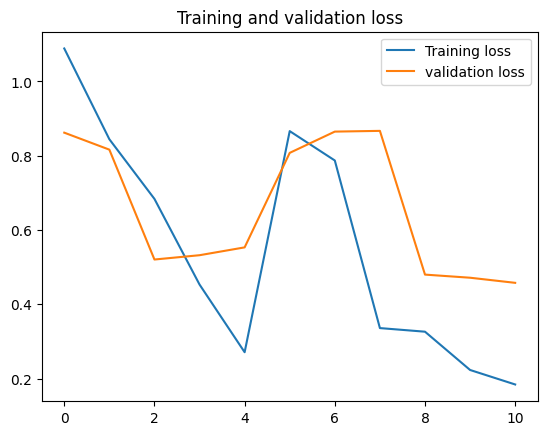

In [65]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc,label="Training accuracy")
plt.plot(epochs, val_acc,label="validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss,label="Training loss")
plt.plot(epochs, val_loss,label="validation loss")
plt.legend()
plt.title('Training and validation loss')


## EVALUATE MODEL

In [40]:
import matplotlib.pyplot as plt
#import numpy
#from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for test data
y_pred = model.predict(test_data).argmax(axis=1)  # Predicted labels
y_true = test_data.classes  # Ground truth labels

cm = confusion_matrix(y_true, y_pred)

cm

4/4 [==============================] - 11s 2s/step


array([[30,  0],
       [ 4, 26]])

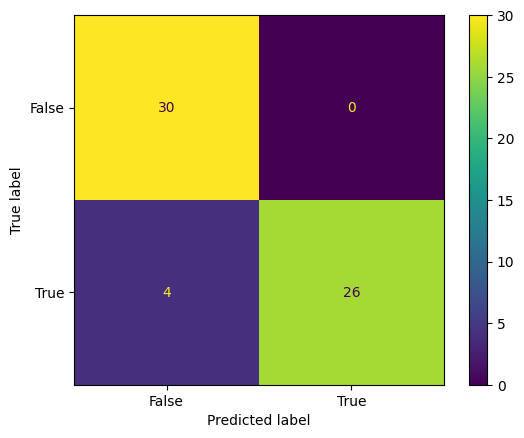

In [41]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

In [80]:
tp = cm[1][1]
fn = cm[1][0]
fp = cm[0][1]
tn = cm[0][0]

accuracy = (tp+tn)/(tp+fn+fp+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

def evaluate_model(cm):
  tp = cm[1][1]
  fn = cm[1][0]
  fp = cm[0][1]
  tn = cm[0][0]

  accuracy = (tp+tn)/(tp+fn+fp+tn)
  recall = tp/(tp+fn)
  specificity = tn/(tn+fp)
  precision = tp/(tp+fp)
  f1_score = (2*precision*recall)/(precision+recall)

  return accuracy, recall, specificity,  precision, f1_score

accuracy, recall, specificity,  precision, f1_score = evaluate_model(cm)
print("Accuracy: {:.2f}".format(accuracy))
print("Recall: {:.2f}".format(recall))
print("Specificity: {:.2f}".format(specificity))
print("Precision: {:.2f}".format(precision))
print("F1-Score: {:.2f}".format(f1_score))

Accuracy: 0.93
Recall: 0.87
Specificity: 1.00
Precision: 1.00
F1-Score: 0.93


In [46]:
from sklearn.metrics import f1_score

# Compute F1 score for Validation
f1 = f1_score(y_true, y_pred)

print("F1 Score: {:.2f}".format(f1))
print(y_true)
print(y_pred)

F1 Score: 0.93
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1]


In [66]:
# convert the history.history dict to a pandas DataFrame:  
import pandas as pd   
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

hist_df

,loss,accuracy,f1_score,val_loss,val_accuracy,val_f1_score
0,1.088696,0.704167,"[0.6899563, 0.7171315]",0.862025,0.850000,"[0.8695652, 0.82352936]"
1,0.844317,0.841667,"[0.8376068, 0.8455285]",0.816302,0.900000,"[0.90909094, 0.88888896]"
2,0.683676,0.875000,"[0.8739496, 0.876033]",0.520468,0.933333,"[0.9310345, 0.9354838]"
3,0.453109,0.904167,"[0.9045644, 0.9037657]",0.532059,0.900000,"[0.9032258, 0.8965517]"
4,0.270867,0.929167,"[0.9300412, 0.92827004]",0.553166,0.883333,"[0.88524586, 0.88135594]"
5,0.866179,0.829167,"[0.83921576, 0.8177778]",0.807612,0.883333,"[0.89552236, 0.8679245]"
6,0.787107,0.862500,"[0.8533333, 0.87058824]",0.864875,0.900000,"[0.90909094, 0.88888896]"
7,0.335856,0.920833,"[0.9184549, 0.9230769]",0.866855,0.900000,"[0.90909094, 0.88888896]"
8,0.326124,0.933333,"[0.9338843, 0.93277305]",0.479845,0.883333,"[0.88135594, 0.88524586]"
9,0.223040,0.950000,"[0.95, 0.95]",0.471442,0.916667,"[0.9230769, 0.90909094]"


## SAVE MODEL IN H5 AND CONVERT TO TFLITE

In [70]:
from keras.models import save_model
save_model(model, 'Model/acc' +str(accuracy)+ '_0.2_ideal_detect_freshness_spinach.h5')
accuracy

0.9333333333333333

In [73]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

# Save the model.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

## TESTING THE MODEL

In [78]:
import numpy as np
from google.colab import files
from keras.models import load_model
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)
  output_class= np.argmax(classes)
  classname = ['Fresh', 'Not fresh']
  print("The predicted class is", classname[output_class])

Saving Spinach_not_fresh (6).jpg to Spinach_not_fresh (6).jpg
Saving Spinach_not_fresh (7).jpg to Spinach_not_fresh (7).jpg
Saving Spinach_not_fresh (8).jpeg to Spinach_not_fresh (8).jpeg
Saving Spinach_not_fresh (10).jpeg to Spinach_not_fresh (10).jpeg
Saving Spinach_not_fresh (11).jpeg to Spinach_not_fresh (11).jpeg
Saving Spinach_not_fresh (12).jpeg to Spinach_not_fresh (12).jpeg
1/1 [==============================] - 0s 296ms/step
Spinach_not_fresh (6).jpg
[[5.8191785e-09 1.0000000e+00]]
The predicted class is Not fresh
1/1 [==============================] - 0s 296ms/step
Spinach_not_fresh (7).jpg
[[0.89149845 0.45750666]]
The predicted class is Fresh
1/1 [==============================] - 0s 300ms/step
Spinach_not_fresh (8).jpeg
[[1.9441139e-05 9.9999923e-01]]
The predicted class is Not fresh
1/1 [==============================] - 0s 212ms/step
Spinach_not_fresh (10).jpeg
[[1.2158861e-04 9.9999785e-01]]
The predicted class is Not fresh
1/1 [==============================] - 0s 156